In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

Cache entry deserialization failed, entry ignored


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

AttentionWithContext.py		 plot_history.pyc	X_train_full.npy
colab_setup.py			 __pycache__		X_train.npy
colab_setup.pyc			 roc_auc_callback.py	X_val.npy
custom_fast_text_embeddings.npy  sample_submission.csv	y_test.npy
datalab				 train_model.py		y_train_full.npy
fast_text_embeddings.npy	 X_submission.npy	y_train.npy
plot_history.py			 X_test.npy		y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
file_import = drive.CreateFile({'id':'1gV3lTGPAL-x0c-EqZXyF4saHo7AVLN4j'})
file_import.GetContentFile('AttentionWithContext.py') 

from AttentionWithContext import AttentionWithContext

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [11]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

features_1 = one_by_one(filtersNumber, embedding_dropout)
features_2 = one_by_one(filtersNumber, embedding_dropout)
features_3 = one_by_one(filtersNumber, embedding_dropout)

features = concatenate([features_1, features_2, features_3])
features = yoon_kim_feature_extractor(filtersNumber, features)

attention_features = AttentionWithContext()(features_3)

features = concatenate([features, attention_features])

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________

In [12]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21312/102124 [=====>........................] - ETA: 10:47 - loss: 0.1731 - acc: 0.9336

102112/102124 [============================>.] - ETA: 0s - loss: 0.0841 - acc: 0.9691

102124/102124 [==============================] - 864s 8ms/step - loss: 0.0841 - acc: 0.9691 - val_loss: 0.0607 - val_acc: 0.9779
Epoch 2/32
 10144/102124 [=>............................] - ETA: 12:00 - loss: 0.0557 - acc: 0.9791

102112/102124 [============================>.] - ETA: 0s - loss: 0.0527 - acc: 0.9805

102124/102124 [==============================] - 859s 8ms/step - loss: 0.0527 - acc: 0.9805 - val_loss: 0.0450 - val_acc: 0.9829
roc-auc: 0.9871 - roc-auc_val: 0.9833                                                                                                    
Epoch 3/32
  8672/102124 [=>............................] - ETA: 12:12 - loss: 0.0480 - acc: 0.9823

102112/102124 [============================>.] - ETA: 0s - loss: 0.0492 - acc: 0.9814

102124/102124 [==============================] - 859s 8ms/step - loss: 0.0492 - acc: 0.9814 - val_loss: 0.0434 - val_acc: 0.9832
Epoch 4/32
 10144/102124 [=>............................] - ETA: 12:00 - loss: 0.0475 - acc: 0.9814

102112/102124 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9820

102124/102124 [==============================] - 859s 8ms/step - loss: 0.0467 - acc: 0.9820 - val_loss: 0.0417 - val_acc: 0.9839
roc-auc: 0.9912 - roc-auc_val: 0.9874                                                                                                    
Epoch 5/32
  8672/102124 [=>............................] - ETA: 12:13 - loss: 0.0426 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0447 - acc: 0.9828

102124/102124 [==============================] - 859s 8ms/step - loss: 0.0447 - acc: 0.9828 - val_loss: 0.0407 - val_acc: 0.9844
Epoch 6/32
 10144/102124 [=>............................] - ETA: 11:59 - loss: 0.0420 - acc: 0.9835

102112/102124 [============================>.] - ETA: 0s - loss: 0.0433 - acc: 0.9831

102124/102124 [==============================] - 859s 8ms/step - loss: 0.0433 - acc: 0.9831 - val_loss: 0.0411 - val_acc: 0.9842
roc-auc: 0.9928 - roc-auc_val: 0.9875                                                                                                    
Epoch 7/32
  8672/102124 [=>............................] - ETA: 12:14 - loss: 0.0420 - acc: 0.9838

102112/102124 [============================>.] - ETA: 0s - loss: 0.0418 - acc: 0.9835

102124/102124 [==============================] - 860s 8ms/step - loss: 0.0418 - acc: 0.9835 - val_loss: 0.0414 - val_acc: 0.9842

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002679433673620224.
Epoch 8/32
  8032/102124 [=>............................] - ETA: 12:16 - loss: 0.0398 - acc: 0.9840

102112/102124 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9842

102124/102124 [==============================] - 860s 8ms/step - loss: 0.0401 - acc: 0.9842 - val_loss: 0.0410 - val_acc: 0.9844
roc-auc: 0.9936 - roc-auc_val: 0.9871                                                                                                    
Epoch 9/32
  8672/102124 [=>............................] - ETA: 12:11 - loss: 0.0392 - acc: 0.9843

102112/102124 [============================>.] - ETA: 0s - loss: 0.0389 - acc: 0.9845

102124/102124 [==============================] - 860s 8ms/step - loss: 0.0389 - acc: 0.9845 - val_loss: 0.0431 - val_acc: 0.9836
Epoch 10/32
 10112/102124 [=>............................] - ETA: 12:00 - loss: 0.0374 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0377 - acc: 0.9848

102124/102124 [==============================] - 860s 8ms/step - loss: 0.0377 - acc: 0.9848 - val_loss: 0.0414 - val_acc: 0.9845
roc-auc: 0.9935 - roc-auc_val: 0.9876                                                                                                    
Epoch 11/32
  8672/102124 [=>............................] - ETA: 12:12 - loss: 0.0364 - acc: 0.9858

102112/102124 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9853

102124/102124 [==============================] - 861s 8ms/step - loss: 0.0363 - acc: 0.9853 - val_loss: 0.0413 - val_acc: 0.9844
Epoch 12/32
 10112/102124 [=>............................] - ETA: 12:00 - loss: 0.0346 - acc: 0.9857

102112/102124 [============================>.] - ETA: 0s - loss: 0.0355 - acc: 0.9858

102124/102124 [==============================] - 860s 8ms/step - loss: 0.0355 - acc: 0.9858 - val_loss: 0.0420 - val_acc: 0.9845
roc-auc: 0.9944 - roc-auc_val: 0.9866                                                                                                    
Epoch 13/32
  8672/102124 [=>............................] - ETA: 12:10 - loss: 0.0336 - acc: 0.9862

102112/102124 [============================>.] - ETA: 0s - loss: 0.0344 - acc: 0.9860

102124/102124 [==============================] - 860s 8ms/step - loss: 0.0344 - acc: 0.9860 - val_loss: 0.0412 - val_acc: 0.9843
Epoch 14/32
 10112/102124 [=>............................] - ETA: 11:59 - loss: 0.0327 - acc: 0.9865

102112/102124 [============================>.] - ETA: 0s - loss: 0.0331 - acc: 0.9864

102124/102124 [==============================] - 860s 8ms/step - loss: 0.0331 - acc: 0.9864 - val_loss: 0.0425 - val_acc: 0.9843
roc-auc: 0.9949 - roc-auc_val: 0.9872                                                                                                    
Epoch 15/32
  8672/102124 [=>............................] - ETA: 12:12 - loss: 0.0322 - acc: 0.9864

102112/102124 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9867

102124/102124 [==============================] - 861s 8ms/step - loss: 0.0326 - acc: 0.9867 - val_loss: 0.0427 - val_acc: 0.9843


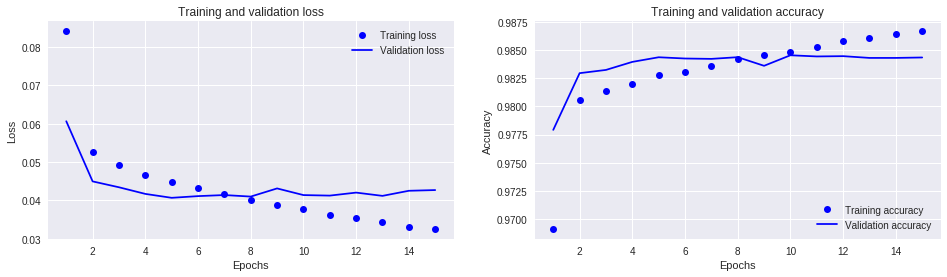

In [13]:
plot_history(history)

In [14]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 79s 2ms/step
([0.040300174151082835, 0.9849495924604214], 0.9890606305024812)
